In [1]:
from ckine.figures.figure2 import pstat_calc, calc_surf_gc, import_samples, data_path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm, os
from os.path import join

/home/adamw/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
unkVec, scales = import_samples()

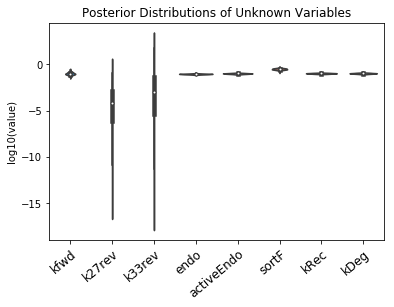

In [3]:
def violinPlots():
    """ Create violin plots of model posterior. """
    unkVec2 = unkVec.transpose()
    
    true_unknowns = np.array([unkVec2[:, 6], unkVec2[:, 13], unkVec2[:, 15], unkVec2[:, 17], unkVec2[:, 18], unkVec2[:, 19], unkVec2[:, 20], unkVec2[:, 21]])
    true_unknowns = true_unknowns.transpose()
    true_unknowns = pd.DataFrame(true_unknowns)
    
    true_unknowns.columns = ['kfwd', 'k27rev', 'k33rev', 'endo', 'activeEndo', 'sortF', 'kRec', 'kDeg']
    a = sns.violinplot(data=np.log10(true_unknowns))  # creates names based on dataframe columns
    a.set_xticklabels(a.get_xticklabels(),
                       rotation=40,
                       rotation_mode="anchor",
                       ha="right",
                       fontsize=12)
    a.set(ylabel='log10(value)', title='Posterior Distributions of Unknown Variables')

    
violinPlots()

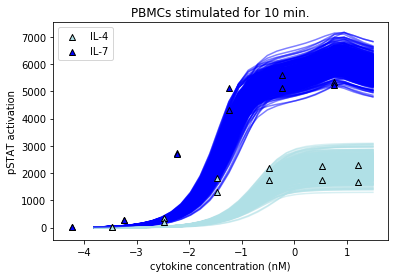

In [4]:
def pstat_plot():
    ''' This function calls the pstat_calc function to re-generate Gonnord figures S3B and S3C with our own fitting data. '''
    PTS = 30
    cytokC_4 = np.array([5., 50., 500., 5000., 50000., 250000.]) / 14900. # 14.9 kDa according to sigma aldrich
    cytokC_7 = np.array([1., 10., 100., 1000., 10000., 100000.]) / 17400. # 17.4 kDa according to prospec bio
    cytokC_common = np.logspace(-3.8, 1.5, num=PTS)
    dataIL4, dataIL7 = data_path()
    
    def plot_structure(IL4vec, IL7vec, title):
        plt.title(title)
        plt.plot(np.log10(cytokC_common), IL4vec, color='powderblue', alpha=0.5)
        plt.plot(np.log10(cytokC_common), IL7vec, color='b', alpha=0.5) 
        plt.ylabel('pSTAT activation' )
        plt.xlabel('cytokine concentration (nM)')

    for ii in range(0,500):
        output = pstat_calc(unkVec[:,ii], scales[ii,:], cytokC_common)
        IL4_output = output[0:PTS]
        IL7_output = output[PTS:(PTS*2)]

        plot_structure(IL4_output, IL7_output, "PBMCs stimulated for 10 min.")
        
    plt.scatter(np.log10(cytokC_4), dataIL4[:,1], color='powderblue', marker='^', edgecolors='k', zorder=100)
    plt.scatter(np.log10(cytokC_4), dataIL4[:,2], color='powderblue', marker='^', edgecolors='k', zorder=200, label='IL-4')
    plt.scatter(np.log10(cytokC_7), dataIL7[:,1], color='b', marker='^', edgecolors='k', zorder=300)
    plt.scatter(np.log10(cytokC_7), dataIL7[:,2], color='b', marker='^', edgecolors='k', zorder=400, label='IL-7')
    plt.legend()
    
pstat_plot()

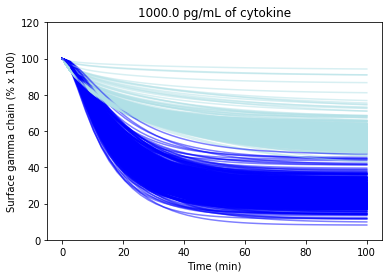

In [9]:
def surf_gc(cytokC_pg):
    size = 40
    ts = np.linspace(0., 100., num=size)
    output = calc_surf_gc(ts, cytokC_pg)
    IL4vec = output[:, 0:size]
    IL7vec = output[:, size:(size*2)]
    
    for ii in range(500):
        plt.plot(ts, IL4vec[ii, :], color='powderblue', alpha=0.5, zorder=ii)
        plt.plot(ts, IL7vec[ii, :], color='b', alpha=0.5, zorder=ii)
    
    plt.title(str(round(cytokC_pg, 0)) + ' pg/mL of cytokine')
    plt.ylim(0,120)
    plt.ylabel("Surface gamma chain (% x 100)")
    plt.xlabel("Time (min)")
    
surf_gc(1000.) 

In [6]:
from sklearn.metrics import r2_score

In [7]:
def calc_R2X():
    cytokC_4 = np.array([5., 50., 500., 5000., 50000., 250000.]) / 14900. # 14.9 kDa according to sigma aldrich
    cytokC_7 = np.array([1., 10., 100., 1000., 10000., 100000.]) / 17400. # 17.4 kDa according to prospec bio
    dataIL4, dataIL7 = data_path()
    dataIL4 = np.mean((dataIL4[:,1], dataIL4[:,2]), axis=0)
    dataIL7 = np.mean((dataIL7[:,1], dataIL7[:,2]), axis=0)
    R2X_4 = np.zeros((500))
    R2X_7 = R2X_4.copy()
    for ii in range(0,500):
        IL4_output = pstat_calc(unkVec[:,ii], scales[ii,:], cytokC_4)
        IL4_output = IL4_output[0:6]
        R2X_4[ii] = r2_score(IL4_output, dataIL4)
        IL7_output = pstat_calc(unkVec[:,ii], scales[ii,:], cytokC_7)
        IL7_output = IL7_output[6:(6*2)]
        R2X_7[ii] = r2_score(IL7_output, dataIL7)
        
    final_R2X_4 = np.mean(R2X_4)
    final_R2X_4 = round(final_R2X_4, 3)
    print("final R2X of IL4 data is " + str(final_R2X_4))
    final_R2X_7 = np.mean(R2X_7)
    final_R2X_7 = round(final_R2X_7, 3)
    print("final R2X of IL7 data is " + str(final_R2X_7))

In [8]:
calc_R2X()

final R2X of IL4 data is 0.577
final R2X of IL7 data is 0.798
